# POMDP's for Personalized Mammography Screening 

Alexander Goldberg, Lydia Goldberg, and Gabriela Merz 

## 1. Pre-generated Alpha Vectors

We have pre-generated all of the alpha vectors needed to solve the POMDP for you. If you would like to re-generate these alpha vectors (**warning: takes on the order of hours even with a commercial grade Linear Program Solver**) proceed to section 3. If you would like to use our pre-generated alpha vectors to play around with our results, continue in this section. 

Make sure you have run 

    pip install -r requirements.txt 
    
before attempting to use this notebook

In [62]:
from monahan import MonahanSolve
from model import CancerPOMDP
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline

We have pre-generated the alpha vectors for you for 20, 40, and 80 timesteps, corresponding to a patient living to ages 50, 60, and 80, respectively. Please choose the alpha vectors you would like to use in the cell below, which is defaulted to 80 timesteps.

In [2]:
NUM_VECTORS = 80

Here we initialize the cancerPOMDP and read in the appropriate alpha vectors 

In [3]:
cancerPOMDP = MonahanSolve()

In [4]:
cancerPOMDP.readAlpha('alpha/Simple/alpha' + str(NUM_VECTORS) + '.txt')

In [51]:
MAMMOGRAM_DICT = {0: 'WAIT', 1: 'GET A MAMMOGRAM'}

Now, we can experiment with different initial ages and different belief states! We can call "cancerPOMDP.chooseAction( beliefstate, time)" to see whether or not we should get a mammogram based on our initial probabilities!

In [60]:
# list of initial beliefs
# 0th index: probability you're healthy 
# first index: probability you have in-situ cancer 
# second index: probability you have invasive cancer 
# feel free to make these numbers up to test if our results are intuitive 
INITIAL_PROBS = [1, 0, 0]
AGE = 40

In [61]:
print MAMMOGRAM_DICT[cancerPOMDP.chooseAction(INITIAL_PROBS, AGE - 40 * .5)]

WAIT


Good! So if you're probability is 1 of being healthy, you opt to wait. Let's delve even futher into the data

## 2. Examining the Data

We want to be able to see what kind of decisions we make under different conditions, 
i.e different initial probabilities of cancers and health, and different ages. 
We create the function "genDF" to generate a dataframe of the decisions we make under
different probabilities, which we will then use to plot and visualize our results. Feel free to play around with how we generate the probabilities for the dataframe: right now, we look in discrete increments of .05, because it is easy to visualize on our heatmap below and doesn't take too long to generate. 

In [23]:
def genDF(pomdp): 
    '''
        function genDF
        
        params: pomdp MonohanSolve class 
        
        returns: a dataframe with columns 
        'Age': Age at which each decision was made, incremented by 5 years
            from 40 - max-age
        'Healthy Prior': Prior probability of health 
        'Insitu Prior' : Prior probability of in-situ cancer 
        'Inviasive Prior': Prior probability of invasive cancer
        'Decision' : 0 or 1, 0 to wait, 1 to get a Mammogram
    '''
    time, insitu, invasive, healthy, decisions = [], [], [], [], []
    for t in range(0, NUM_VECTORS + 1, 10): 
        for insitu_prob in range(50): 
            insitu_prob = .05 * insitu_prob
            for invasive_prob in range(50): 
                invasive_prob = .05 * invasive_prob
                if insitu_prob + invasive_prob > 1: 
                    continue 
                else: 
                    healthy_prob = 1 - insitu_prob - invasive_prob 
                    decision = pomdp.chooseAction([healthy_prob, insitu_prob, invasive_prob], t)
                    time.append((t * .5) + 40)
                    insitu.append(insitu_prob)
                    invasive.append(invasive_prob)
                    healthy.append(healthy_prob)
                    decisions.append(decision)
    return pd.DataFrame({'Age': time, 'Healthy Prior': healthy, 'Insitu Prior': insitu, 'Invasive Prior': 
                             invasive, 'Decision': decisions})                    

Now, we generate a table of all the information!

In [24]:
df = genDF(cancerPOMDP)

You can feel free to play with the information like so: 

In [38]:
# look at the first five entries of the dataframe 
df.head()

,Age,Decision,Healthy Prior,Insitu Prior,Invasive Prior
0,40.0,0,1.00,0.0,0.00
1,40.0,1,0.95,0.0,0.05
2,40.0,1,0.90,0.0,0.10
3,40.0,1,0.85,0.0,0.15
4,40.0,1,0.80,0.0,0.20


In [47]:
# look at every probability distribution we opt to wait instead of
# recieving a mammogram
df[df['Decision'] == 0]

,Age,Decision,Healthy Prior,Insitu Prior,Invasive Prior
0,40.0,0,1.00,0.00,0.00
231,45.0,0,1.00,0.00,0.00
462,50.0,0,1.00,0.00,0.00
693,55.0,0,1.00,0.00,0.00
924,60.0,0,1.00,0.00,0.00
1155,65.0,0,1.00,0.00,0.00
1386,70.0,0,1.00,0.00,0.00
1407,70.0,0,0.95,0.05,0.00
1617,75.0,0,1.00,0.00,0.00
1618,75.0,0,0.95,0.00,0.05


The dataframe is good and all, but you probably want to see some actual ~visualizations~. 
In that case, we define a function "plotAge" which takes in the dataframe we generated
and an age (from 40 - 75, incremented in 5's), and plots a heatmap. The x axis of the 
heatmap is your prior probability of in-situ cancer, and the y axis of your heatmap 
is your prior probability of invasive cancer. A square is red if you should opt to get
a mammogram for those probabilities, and a square is blue if you should opt to wait
instead of getting a mammogram. Note that we are not looking at probabilities in continuous space, but in discreet intervals of .05.

In [48]:
def plotAge(df, age): 
    '''
        function that plots a heatmap 
        of insitu prior vs. invasive prior
        blue squares indicate you opt to wait, 
        red square indicate you should recieve 
        a mammogram
    '''
    new_df = df[df['Age'] == age]
    new_df = new_df.pivot("Invasive Prior", "Insitu Prior", "Decision")
    ax = sns.heatmap(new_df, cmap=ListedColormap(['blue', 'red']), alpha = .2, cbar = False)
    ax.set_title('Mammogram Decisions for Age %s' % age)
    ax.invert_yaxis()

Let's plot the data for age 40!

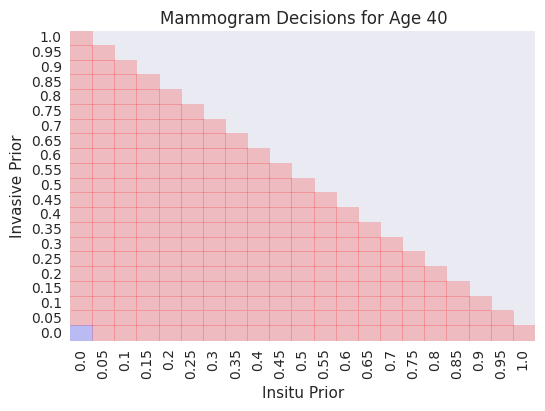

In [26]:
plotAge(df, 40)

So far, this is consistent with the results from the original paper. Let's see what happens when we up the age to 70: 

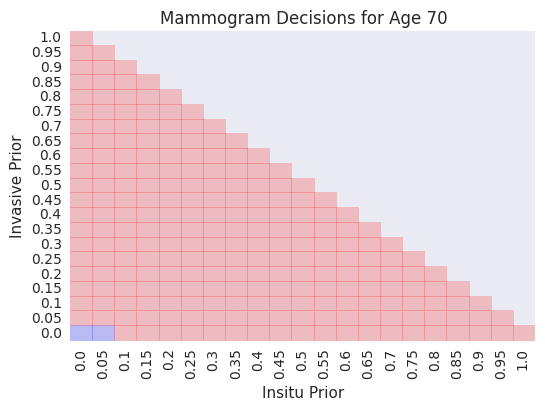

In [27]:
plotAge(df, 70)

Good! This is exactly the behavior we would expect. As we get older, the risk assosciated with a mammogram because less important than the reward (which, as a refresher, is measured in Quality of Life Years or QALYs). So we become more likely to wait instead of opting to recieve a mammogram. 

## 3. Re-solving the POMDP

If you would like to re-solve the POMDP, and have installed everything in requirements.txt, you should be able to run the following command to solve the POMDP (find the alpha vectors). In our write-up, we describe the various LP solvers we used to optimize, however we cannot offer you commercial grade solvers, so you will have to use pulp (which is slower, but works). 


This command will generate the alpha vectors, and you will see a series of output including 

1. which LP solver you're using
2. The total number of alpha vectors at each timestep 
3. The total number of alpha vectors after Eagle's reduction 
4. The total number of alpha vectors after solving the Linear Program
5. Which time step you're on 
6. The ammount of time it took for each step to run

If you would like to change the default number of timesteps, whether or not you write to a file, etc. please feel free to look through the code in model.py and monohan.py and modify settings as you prefer

In [63]:
newPOMDP = MonahanSolve().solve()

Using LP Solver pulp 

Total alpha after enumeration: 2, time: 0.00
Total alpha after Eagle: 1, time: 0.00
Total alpha after LP: 1, time: 0.00
	LP construct time:  0
	LP solve time:  0
Completed time step  119 

Total alpha after enumeration: 2, time: 0.00
Total alpha after Eagle: 2, time: 0.00
Total alpha after LP: 2, time: 0.08
	LP construct time:  0.00948023796082
	LP solve time:  0.0746712684631
Completed time step  118 

Total alpha after enumeration: 6, time: 0.00
Total alpha after Eagle: 5, time: 0.00
Total alpha after LP: 4, time: 0.08
	LP construct time:  0.00986194610596
	LP solve time:  0.0736651420593
Completed time step  117 

Total alpha after enumeration: 20, time: 0.00
Total alpha after Eagle: 11, time: 0.00
Total alpha after LP: 8, time: 0.20
	LP construct time:  0.0361468791962
	LP solve time:  0.157537221909
Completed time step  116 

Total alpha after enumeration: 72, time: 0.01
Total alpha after Eagle: 32, time: 0.00
Total alpha after LP: 13, time: 0.72
	LP constru

KeyboardInterrupt: 